In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
lmod_4_a00=np.load("lmod_4_a00.npy")
lmod_lmax_a00=np.load("lmod_lmax_a00.npy")

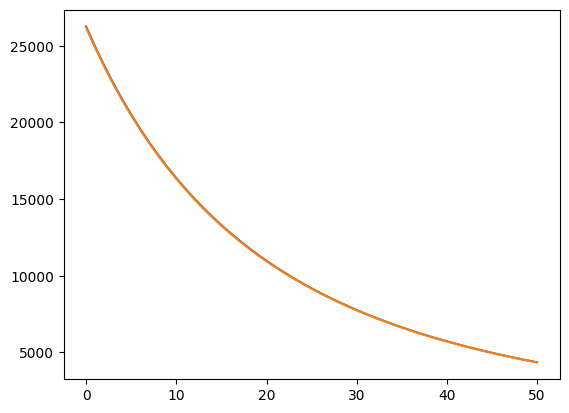

In [16]:
plt.plot(lmod_4_a00)
plt.plot(lmod_lmax_a00)

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_18222/2467986521.py:1: RuntimeWarning: overflow encountered in exp
  f = lambda x, A, alpha, b: A*1e3*x**(-alpha)*np.exp(b*np.log(x)**2)


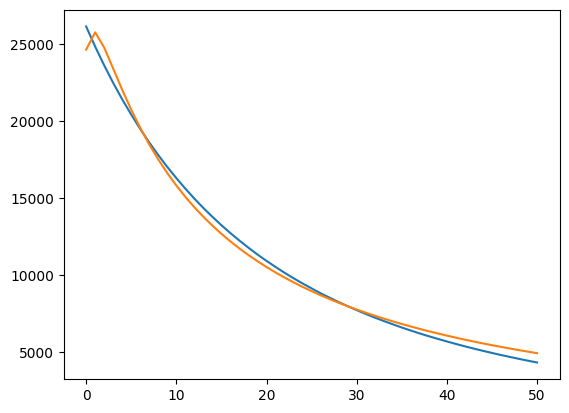

In [20]:
f = lambda x, A, alpha, b: A*1e3*x**(-alpha)*np.exp(b*np.log(x)**2)
xx = np.array(list(range(1, 52)))
res_4 = curve_fit(f, xx, lmod_4_a00)
res_lmax = curve_fit(f, xx, lmod_lmax_a00, p0=[10, 2.5, 0.01])

plt.plot(lmod_lmax_a00)
plt.plot(f(xx,*res_lmax[0]))


In [42]:
import src.forward_model as FM
from src.blockmat import BlockMatrix
reload(FM)

<module 'src.forward_model' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py'>

In [43]:
def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return fg_a00_terms

In [48]:
nuarr = np.linspace(50, 100, 51)
Nfreq = len(nuarr)
Nbin  = 2
Nlmod = 3
A_dummy = np.zeros((Nfreq, Nbin, Nlmod))
A_dummy = BlockMatrix(mat=A_dummy)
mod = FM.generate_binwise_forward_model(nuarr, A_dummy, Npoly=4)

In [56]:
theta_test       = [10, 2.5, .001, -.001]
theta_test_extra = [9 , 2.1, -.001, .001]
theta_mod  = np.array(theta_test+theta_test_extra, dtype=np.float128)
theta_test       = np.array(theta_test)
theta_test_extra = np.array(theta_test_extra)

theta_mod[0] = np.log(theta_mod[0]*1e3)
theta_mod[1] = -theta_mod[1]
theta_mod[4] = np.log(theta_mod[4]*1e3)
theta_mod[5] = -theta_mod[5]

d_test       = fg_polymod(nuarr, *theta_test)
d_test_extra = fg_polymod(nuarr, *theta_test_extra)
d_mod = mod(theta_mod)


In [57]:
d_mod.shape

(102,)

In [60]:
theta_mod

array([ 9.21034037e+00, -2.50000000e+00,  1.00000000e-03, -1.00000000e-03,
        9.10497986e+00, -2.10000000e+00, -1.00000000e-03,  1.00000000e-03],
      dtype=float128)

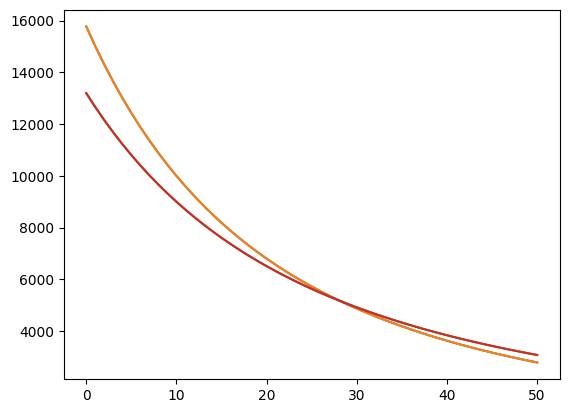

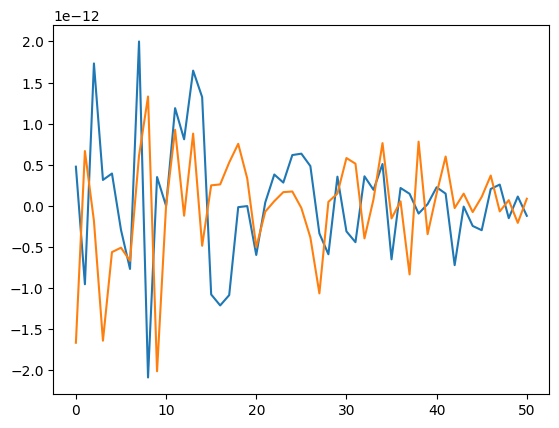

In [58]:
plt.plot(d_test)
plt.plot(np.split(d_mod, 2)[0])
plt.plot(d_test_extra)
plt.plot(np.split(d_mod, 2)[1])
plt.show()
plt.plot(d_test-np.split(d_mod, 2)[0])
plt.plot(d_test_extra-np.split(d_mod, 2)[1])
plt.show()

In [25]:
theta_test       = [10, 2.5, .001, -.001]
theta_test_extra = [9, 2.1, -.001, .001]


theta_mod  = np.array(theta_test+theta_test_extra, dtype=np.float128)
theta_test       = np.array(theta_test, dtype=np.float128)
theta_test_extra = np.array(theta_test_extra, dtype=np.float128)
theta_mod[0] = np.log(theta_mod[0]*1e3)
theta_mod[1] = -theta_mod[1]
theta_mod[4] = np.log(theta_mod[4]*1e3)
theta_mod[5] = -theta_mod[5]

d_test       = fg_polymod(nuarr, *theta_test)
d_test_extra = fg_polymod(nuarr, *theta_test_extra)
d_mod = mod(theta_mod)


array([ 9.0e+00,  2.1e+00, -1.0e-03,  1.0e-03], dtype=float128)

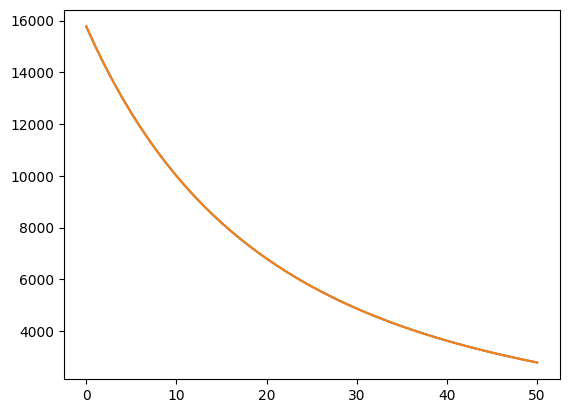

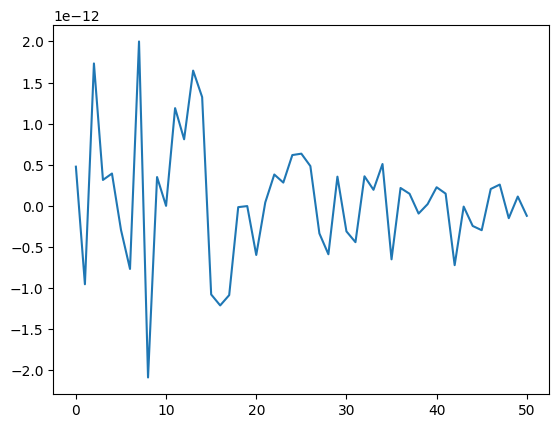

In [47]:
plt.plot(d_test)
plt.plot(d_mod)
plt.show()
plt.plot(d_test-d_mod)
plt.show()